In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train = train.drop(train.index[4000:7000])

test = test.drop(test.index[1500:2947])

train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

alldf = pd.concat([train, test], axis=0).reset_index(drop=True)


### Veri eşit dağılmış mı?
Verilerin eşit dağıldığına aşağıdaki grafikte görebiliriz

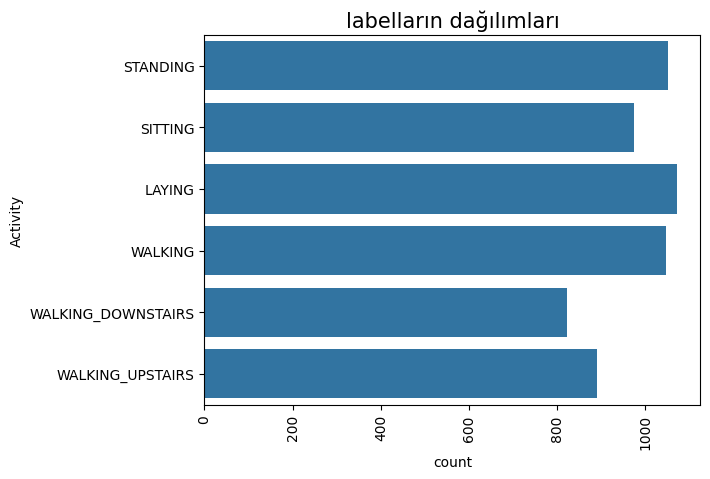

In [2]:
import seaborn as sns
plt.title('labelların dağılımları', fontsize=15)
sns.countplot(alldf.Activity)
plt.xticks(rotation=90)
plt.show()

In [3]:
from collections import Counter
pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in alldf.columns]), orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

,count
fBodyAcc,79
fBodyGyro,79
fBodyAccJerk,79
tGravityAcc,40
tBodyAcc,40
tBodyGyroJerk,40
tBodyGyro,40
tBodyAccJerk,40
tBodyAccMag,13
tGravityAccMag,13


### Verimizin sınıflandırabileceğini görebilmek için TSNE haritası oluşturalım

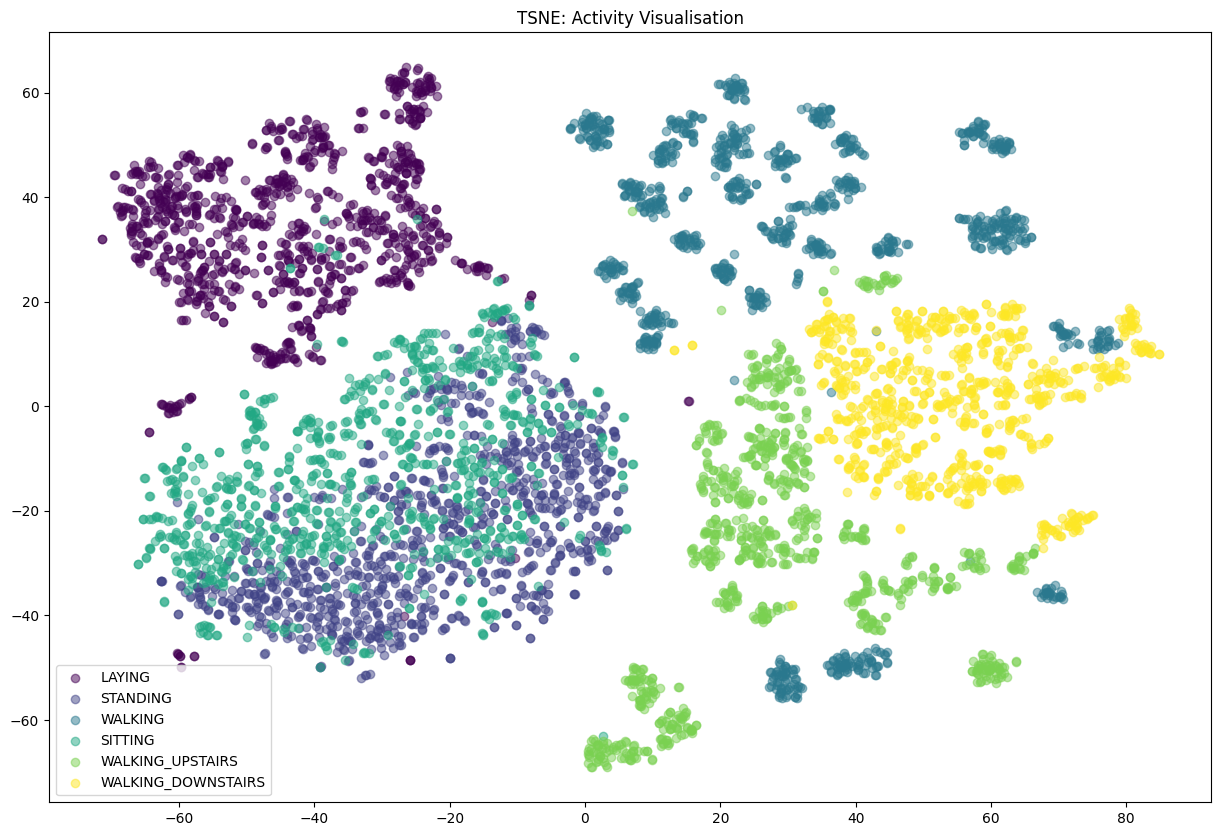

In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from matplotlib.colors import rgb2hex
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.cm import get_cmap

# Create datasets
tsne_data = alldf.copy()
label = tsne_data.pop('Activity')
label_counts = label.value_counts()

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions (speed up)
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)


# Create subplots
fig, ax = plt.subplots(figsize=(15,10))

### Plot Activities
# Get colors
n = label.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (label==group).values
    ax.scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
ax.set_title('TSNE: Activity Visualisation')
ax.legend()


### Grid search ve cross validationu birlikte kullanarak en iyi değeri bulalım

In [5]:
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
parameters = {'C':[0.125, 0.5, 1, 2, 8, 16]}
lr_svc = LinearSVC(tol=0.00005)
lr_svc_grid = GridSearchCV(lr_svc, param_grid=parameters, n_jobs=-1, verbose=1, cv=5)

In [6]:
y_train = train.Activity
X_train = train.drop(['subject', 'Activity'], axis=1)
y_test = test.Activity
X_test = test.drop(['subject', 'Activity'], axis=1)
print('Training data size : ', X_train.shape)
print('Test data size : ', X_test.shape)

Training data size :  (4352, 561)
Test data size :  (1500, 561)


In [7]:
lr_svc_grid.fit(X_train, y_train)
y_pred = lr_svc_grid.predict(X_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\mkurn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\mkurn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Sensivity recall ve f1-scorelaraı scikit ile yazdıralım

In [8]:
accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
classification_report = metrics.classification_report(y_test, y_pred)
print(classification_report)

                    precision    recall  f1-score   support

            LAYING       1.00      0.97      0.98       270
           SITTING       0.92      0.78      0.84       251
          STANDING       0.80      0.93      0.86       260
           WALKING       0.90      0.99      0.94       274
WALKING_DOWNSTAIRS       0.98      1.00      0.99       218
  WALKING_UPSTAIRS       0.99      0.88      0.93       227

          accuracy                           0.92      1500
         macro avg       0.93      0.92      0.92      1500
      weighted avg       0.93      0.92      0.92      1500



In [9]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[262   0   8   0   0   0]
 [  0 195  53   0   0   3]
 [  0  17 242   1   0   0]
 [  0   0   0 270   4   0]
 [  0   0   0   0 218   0]
 [  0   0   0  28   0 199]]


In [10]:
print("En iyi parametreler:", lr_svc_grid.best_params_)
print("En iyi skor:", lr_svc_grid.best_score_)

En iyi parametreler: {'C': 0.125}
En iyi skor: 0.9276176148435541


In [13]:
 from sklearn import preprocessing


le = preprocessing.LabelEncoder()

y_test_encoded = le.fit_transform(y_test)
y_pred_encoded = le.transform(y_pred)

auc_scores = []

for class_label in range(len(le.classes_)):
    y_true_class = (y_test_encoded == class_label).astype(int)
    y_pred_class = (y_pred_encoded == class_label).astype(int)
    auc = metrics.roc_auc_score(y_true_class, y_pred_class)
    auc_scores.append(auc)

mean_auc = sum(auc_scores) / len(auc_scores)
print("Mean AUC Score:", mean_auc)

Mean AUC Score: 0.9540125095012906


### Boyut azaltarak skora tekrardan bakalım.

In [14]:
from sklearn.model_selection import train_test_split

tsne_data = alldf.copy()
label = tsne_data.pop('Activity')
label_counts = label.value_counts()

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions (speed up)
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

X_train, X_test, y_train, y_test = train_test_split(tsne_data, label, test_size=0.2, random_state=42)


In [15]:
lr_svc_grid.fit(X_train, y_train)
y_pred = lr_svc_grid.predict(X_test)

accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
classification_report = metrics.classification_report(y_test, y_pred)
# store report in results
print(classification_report)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\mkurn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       218
           SITTING       0.94      0.84      0.89       201
          STANDING       0.86      0.95      0.90       193
           WALKING       0.98      1.00      0.99       224
WALKING_DOWNSTAIRS       1.00      0.97      0.99       176
  WALKING_UPSTAIRS       0.96      0.99      0.97       159

          accuracy                           0.96      1171
         macro avg       0.96      0.96      0.96      1171
      weighted avg       0.96      0.96      0.96      1171



C:\Users\mkurn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [16]:
print(accuracy)

0.9564474807856533
